In [1]:
from gridworld import *
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential;
from keras.layers import Dense, Activation;
from keras import initializers;
from keras.optimizers import Adam, SGD;
from keras import backend as K
import pandas as pd
from tqdm import tqdm, trange
%matplotlib inline
#Deep Q-Learning with Risk

#gw = gridworld((5, 5), (0, 0), (4, 0), [(o, 0) for o in range(4)], 0.9, 0, 1, 0)
gw = gridworld((5, 5), (0, 0), (4, 0), [(o, 0) for o in range(1, 4)], 0.9, 0, 1, 0)
# Discount Rate
gamma = 0.95

Using TensorFlow backend.


In [3]:
def loss(Qtarget, Q):
    return K.sum(K.square(Qtarget - Q))

def state_tup_to_num(state_tup):
	state_num = state_tup[0]*gw.M + state_tup[1]
	return state_num

def state_num_to_tup(state_num):
	state_tup = (state_num/gw.M, state_num%gw.M)
	return state_tup



risk_states = np.zeros((gw.M, gw.N))
def dist_error_state(state, error_state):
    return ( np.sqrt( (state[0] - error_state[0])**2 + (state[1] - error_state[1])**2 ) )
for i in range(gw.M):
    for j in range(gw.N):
#         if (i, j) in error_states:
#             risk_states[i,j] == 0.
#         if (i, j) == goal:
#             risk_states[i,j] == 0.
#         else:
        sm = 0.
        for e in gw.error_states:
            sm += np.exp( - dist_error_state([i,j], e) )
        risk_states[i,j] = sm
np.min(risk_states)
np.max(risk_states)
risk_states = (risk_states - np.min(risk_states))/(np.max(risk_states) - np.min(risk_states))

0.034354981311714966

1.7357588823428847

100%|██████████| 1000/1000 [00:34<00:00, 29.33it/s]


Successful episodes: 0.02


<Figure size 648x1152 with 0 Axes>

Text(0.5,1,'Step Moving Average (100-episode window)')

Text(0,0.5,'Moves')

Text(0.5,0,'Episode')

Text(0.5,1,'Reward Moving Average (100-episode window)')

Text(0,0.5,'Reward')

Text(0.5,0,'Episode')

Text(0.5,1,'Loss Moving Average (100-episode window)')

Text(0,0.5,'Loss')

Text(0.5,0,'Episode')

Text(0.5,1,'Random Action Parameter')

Text(0,0.5,'Chance Random Action')

Text(0.5,0,'Episode')

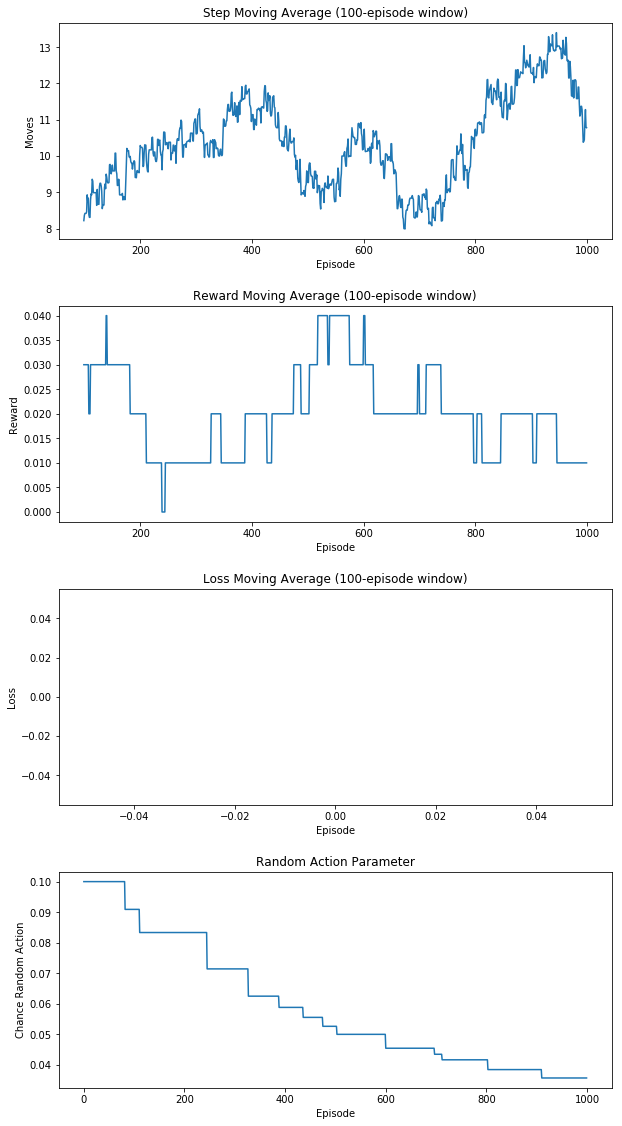

Score over time: 0
Final Q-Table Values


,0,1,2,3,4
0,-26,-17.81,-13.50,-11.13,-4.72
1,E,-10.80,-10.49,-9.11,-7.31
2,E,-7.30,-8.00,-7.56,-7.18
3,E,-5.19,-6.47,-6.48,-5.74
4,G,-3.67,-5.09,-5.50,-2.66


,0,1,2,3,4
0,⬅,➡,➡,➡,⬆
1,E,⬇,➡,⬇,⬆
2,E,⬅,➡,⬅,⬇
3,E,➡,⬇,⬇,⬇
4,G,⬅,⬅,⬇,➡


In [8]:
# Chance of random action
e = 0.1
learning_rate = 0.01
# Training Episodes
episodes = 1000
# Max Steps per episode
steps = 50
factor = 100

# Initialize history memory
step_list = []
reward_list = []
loss_list = []
e_list = []

#Model
initializer = initializers.random_uniform(0, 0.1, seed=1)
model = Sequential([Dense(4, input_dim=gw.M*gw.N, 
                    kernel_initializer=initializer,
                    use_bias=False
                             )])
model.compile(loss=loss, optimizer=Adam(lr=learning_rate))


#Transform into one-hot vector
def OH(l, x):
    return np.identity(l)[x].reshape(1,l)


for i in trange(episodes):
    # Initialize
    state = gw.reset()
    reward_all = 0 #Reward counter
    done = False
    s = 0 #Step counter
    l = 0 #Loss

    for s in range(steps):
        # Choose action randomly or through agent model
        Q = model.predict(OH(gw.M*gw.N, state_tup_to_num(state)), batch_size=1)
        if np.random.rand(1) < e:
            action = np.random.choice([0,1,2,3])
        else:
            action = np.argmax(Q)

        # Take action and obtain new state and reward    
        new_state, reward, done = gw.step(action)

        # Adjust reward if done without reaching end
        #if done and reward == 0.0: reward = -1

        # Find max-Q for future state
        Q1 = model.predict(OH(gw.M*gw.N, state_tup_to_num(new_state)), batch_size=1)
        maxQ1 = np.max(Q1)

        # Bellman Equation
        # Update target for training by adding reward for action and discounted max next state Q-value
        targetQ = Q
        targetQ[0, action] = reward + (gamma * maxQ1) -  factor * risk_states[state[0], state[1]]
#         if new_state in gw.error_states:
#             targetQ[0, action] -= 1
            

        # Train on target Q value
        history = model.fit(OH(gw.M*gw.N, state_tup_to_num(state)), targetQ, verbose=False, batch_size=1)

        # Update history and set current state
        l += history.history['loss'][0]
        reward_all += reward
        state = new_state

        if done == True:
            # Reduce e if current episode is successful
            if reward > 0: 
                e = 1./((i/50) + 10)
            break

    # Update history
    step_list.append(s)
    reward_list.append(reward_all)
    loss_list.append(l/s)
    e_list.append(e)
print('\nSuccessful episodes: {}'.format(np.sum(np.array(reward_list)>0.0)/float(episodes)))

window = int(episodes/10)

plt.figure(figsize=[9,16])
plt.subplot(411)
plt.plot(pd.Series(step_list).rolling(window).mean())
plt.title('Step Moving Average ({}-episode window)'.format(window))
plt.ylabel('Moves')
plt.xlabel('Episode')

plt.subplot(412)
plt.plot(pd.Series(reward_list).rolling(window).mean())
plt.title('Reward Moving Average ({}-episode window)'.format(window))
plt.ylabel('Reward')
plt.xlabel('Episode')

plt.subplot(413)
plt.plot(pd.Series(loss_list).rolling(window).mean())
plt.title('Loss Moving Average ({}-episode window)'.format(window))
plt.ylabel('Loss')
plt.xlabel('Episode')

plt.subplot(414)
plt.plot(e_list)
plt.title('Random Action Parameter')
plt.ylabel('Chance Random Action')
plt.xlabel('Episode')

plt.tight_layout(pad=2)
plt.show()

print "Score over time: " +  str(sum(reward_list)/episodes)
print "Final Q-Table Values"
Q = np.zeros((gw.M,gw.N,4))

for x in range(gw.M):
    for y in range(gw.N):
        Q[x,y,:] = model.predict(OH(gw.M*gw.N, state_tup_to_num((x, y))), batch_size=1)

v = np.mean(Q, axis = 2)
gw.print_v(v)

pi = np.argmax(Q, axis = 2)
gw.print_policy(pi)